In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import ADASYN,SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer,SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,precision_score,f1_score,confusion_matrix,recall_score,classification_report,roc_auc_score,roc_curve

# **Risk Alert Classifier**

### Part B: Dataset Understanding & Preparation

#### 1. Identify input features and target variable.
#### 2. Perform a train test split while maintaining class distribution.
#### 3. Identify missing values and apply KNN Imputer for multivariate imputation.

In [88]:
# Importing The Dataset
df = pd.read_csv("Risk_Alert_Classifier_Dataset_4600 - Risk_Alert_Classifier_Dataset_4600.csv.csv")
df

,customer_id,age,gender,region,employment_type,annual_income_inr,credit_score,credit_utilization_ratio,missed_payments_12m,avg_late_payment_days,monthly_transaction_count,monthly_spend_inr,cash_advance_count_6m,complaints_last_6m,failed_login_attempts_3m,account_tenure_months,last_transaction_date,debt_balance_inr,risk_status
0,500001,43.0,Female,NaN,Salaried,82242.0,NaN,0.120,1,2.2,39,33889.0,0,2,4,70,2025-09-26,87273,0
1,500002,29.0,Female,Central,Salaried,32769.0,647.0,0.337,1,1.5,11,10853.0,1,1,1,34,2025-11-24,20600,0
2,500003,36.0,Male,East,Salaried,39731.0,727.0,0.175,0,3.9,45,25519.0,2,1,1,74,2025-09-26,47565,0
3,500004,28.0,Male,North,Unemployed,38990.0,553.0,0.472,7,23.3,103,17806.0,1,2,6,72,2025-10-03,43803,1
4,500005,36.0,Female,East,Self-Employed,41043.0,732.0,0.418,1,9.8,95,27114.0,0,1,1,11,2025-10-26,12008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,504596,40.0,Male,North,NaN,39337.0,645.0,0.101,0,8.8,49,12591.0,0,0,0,23,2025-09-14,28947,0
4596,504597,35.0,Female,Central,Unemployed,34465.0,622.0,0.325,0,7.3,45,20146.0,3,0,4,18,2025-11-25,32475,0
4597,504598,31.0,Female,East,Self-Employed,NaN,693.0,0.583,1,7.1,36,16338.0,1,1,1,89,2025-09-16,52776,0
4598,504599,43.0,Male,East,Salaried,15000.0,540.0,0.915,4,16.0,60,13870.0,1,1,3,19,2025-09-07,20615,1


- In This Our Dataset We Have About Total 19 Columns Each Describing Whether An Customer Is Risky Or Not, Specifying Each And Every Detail About The Customer His Annual Income, Last_Payments, Employement_Type And Etc.

#### Identifying Input Features And Target Variables From this dataset
- Target Variable : "risk_status"
- Input Features : "employment_type","annual_income_inr","credit_score","missed_payments_12m","monthly_spend_inr","last_transaction_date","debt_balance_inr".

In [89]:
# Identifying Missing Values 
print(f"{df.isnull().sum()}")

customer_id                    0
age                          140
gender                         0
region                       102
employment_type              144
annual_income_inr            166
credit_score                 216
credit_utilization_ratio     147
missed_payments_12m            0
avg_late_payment_days          0
monthly_transaction_count      0
monthly_spend_inr            129
cash_advance_count_6m          0
complaints_last_6m             0
failed_login_attempts_3m       0
account_tenure_months          0
last_transaction_date          0
debt_balance_inr               0
risk_status                    0
dtype: int64


In [90]:
# Listing Down Categorical And Numerical Columns
numerical_cols = df.select_dtypes(include=["int64","float64"]).columns
categorical_cols = df.select_dtypes(include="object").columns

In [91]:
# Filling Missing Values Based On KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5,weights="uniform")
df[numerical_cols] = knn_imputer.fit_transform(df[numerical_cols])

# Filling Missing Categorical Values Based On Simple Imputer
simple_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = simple_imputer.fit_transform(df[categorical_cols])

- Filling Missing Values So We Can Have A Better Understanding And Stability In Our Dataset

In [92]:
# Dropping Irrelevant Columns
df.drop("customer_id",axis=1,inplace=True)

In [93]:
# Creating New Columns From last_transaction_date Which is days_since_last_transaction
df["last_transaction_date"] = pd.to_datetime(df["last_transaction_date"])
df["days_since_last_transaction"] = (pd.Timestamp.today() - df["last_transaction_date"]).dt.days

- So Now we have Both transaction date column also And days_since_last_transaction this is useful for model prediction Where the model will understand better when given days rather than dates

##### **We Will Perform Train Test Split In The Next Part Which Is Below**.

### Part C: Baseline Classification Model

#### 4. Implement Logistic Regression as a baseline model.
#### 5. Generate and interpret:
####         • Confusion Matrix
####         • Accuracy Score
####         • Precision, Recall, F1-Score
#### 6. Identify Type-I and Type-II errors from the confusion matrix.

In [94]:
# Splitting Target Features And Input Features
x = df.drop(columns=["risk_status"])
y = df["risk_status"]

# Train Test Spliting The data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

# Preprocessing And Encoding The Data through ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
    ("StandardScaler",StandardScaler(),(x.select_dtypes(include=["int64","float64"]).columns)),
    ("OneHotEncoder",OneHotEncoder(drop="first",handle_unknown="ignore"),(x.select_dtypes(include="object")).columns)
])

# Preparing The Model Into The Pipeline For Least Data Leakage
logistic_model_pipeline = Pipeline([
    ("preprocessor",preprocessing),
    ("Logistic",LogisticRegression(max_iter=500,random_state=42))
])

logistic_model_pipeline.fit(x_train,y_train)
y_pred = logistic_model_pipeline.predict(x_test)

print(f"Accuracy Score : {accuracy_score(y_test,y_pred)}")
print(f"Precision Score : {precision_score(y_test,y_pred)}")
print(f"Recall Score : {recall_score(y_test,y_pred)}")
print(f"F1-Score : {f1_score(y_test,y_pred)}")

matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion Matric : \n{matrix}")

Accuracy Score : 0.9956521739130435
Precision Score : 0.9906542056074766
Recall Score : 0.9724770642201835
F1-Score : 0.9814814814814815
Confusion Matric : 
[[810   1]
 [  3 106]]


- We Have Created Logistic Regression Model To Predict Risk_Status With Normalizing Columns Using StandardScalar And Encoding Categorical Columns Using OneHotEncoder And For Evalaution Used Accuracy, Precision, Recall And More.

#### Identifying Type-1 And Type-2 Error From The Confusion Matrix
- From The Given Matrix Type-1 Error Are Those Which Reject A True Null Hypothesis Which Means An Customer Risk Status Is 0 (0="Low Risk") But The Model Predicted It 1 (1="High Risk").

- From The Given Matrix Type-2 Error Are Those Which Accept A False Null Hypothesis Which Means An Customer Risk Status Is 1 But The Model Predicted It 0. 

In [95]:
print(f"Type-1(False Positive) Error From The Above Matric : {matrix[0][1]}")
print(f"Type-2(False Negative) Error From The Above Matric : {matrix[1][0]}")

Type-1(False Positive) Error From The Above Matric : 1
Type-2(False Negative) Error From The Above Matric : 3


### Part D: Handling Imbalanced Data

#### 7. Demonstrate the impact of class imbalance on model performance.
#### 8. Apply the following techniques and retrain the model:
#####         • Under-Sampling, Over-Sampling, SMOTE, ADASYN
#### 9. Compare performance before and after balancing using:
#####          • Recall for minority class, F1-Score, AUC-ROC

- Now We Will Again ReTrain The Model With Demonstrating Class Imbalance By Techniques OverSampling, UnderSampling, SMOTE, ADASYN.

In [96]:
# Splitting Target Features And Input Features
x = df.drop(columns=["risk_status"])
y = df["risk_status"]

# Train Test Spliting The data
x_train2,x_test2,y_train2,y_test2 = train_test_split(x,y,test_size=0.2)

In [97]:
# Preprocessing And Encoding The Data through ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
    ("StandardScaler",StandardScaler(),(x.select_dtypes(include=["int64","float64"]).columns)),
    ("OneHotEncoder",OneHotEncoder(drop="first",handle_unknown="ignore"),(x.select_dtypes(include="object")).columns)
])

# Defining All The Sampling Techniques For Optimization And Better Output
samplers = {"RandomUnderSampler" : RandomUnderSampler(random_state=42),
            "SMOTE" : SMOTE(random_state=42),
            "ADASYN" : ADASYN(random_state=42)}


In [98]:
# Preparing The Model Into The Pipeline For Least Data Leakage
lr_model = []
for name,sampler in samplers.items():
    logistic_model_pipeline = ImbPipeline([
        ("preprocessor",preprocessing),
        ("Sampler",sampler),
        ("Logistic",LogisticRegression(max_iter=500,random_state=42))
    ])

    lr_model.append(logistic_model_pipeline.fit(x_train2,y_train2))
    logistic_model_pipeline.fit(x_train2,y_train2)
    y_pred2 = logistic_model_pipeline.predict(x_test2)

    # Evalaution Of This Model
    print(f"Sampling Method : {name}")
    print("=============================================")
    print(f"Accuracy Score : {accuracy_score(y_test2,y_pred2)}")
    print(f"Recall Score : {recall_score(y_test2,y_pred2)}")
    print(f"F1-Score : {f1_score(y_test2,y_pred2)}\n")

Sampling Method : RandomUnderSampler
Accuracy Score : 0.9869565217391304
Recall Score : 0.9827586206896551
F1-Score : 0.95

Sampling Method : SMOTE
Accuracy Score : 0.9923913043478261
Recall Score : 0.9827586206896551
F1-Score : 0.9702127659574468

Sampling Method : ADASYN
Accuracy Score : 0.9891304347826086
Recall Score : 0.9913793103448276
F1-Score : 0.9583333333333334



- Above Are All The Following Techniques Of Sampling Which Improves The Class Imbalance by Adding Or Removing Majority Classes From The Dataset. After Sampling The Performance Is Neither Degradeded Nor Upgradeded Because Our Dataset Is Much Better On Its Own.

#### **Comparing Performance Before And After Balancing**

In [99]:
# Showing Recall Score And F1-Score For Minority Class With The Help Of Classification Report.
print(f"Classification Report Without Balancing Techniques : \n{classification_report(y_test,y_pred)}")
print(f"Classification Report With Balancing Techniques : \n{classification_report(y_test2,y_pred2)}")

# Comaparing Shown With AUC-ROC Score Or Curves
 

Classification Report Without Balancing Techniques : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       811
         1.0       0.99      0.97      0.98       109

    accuracy                           1.00       920
   macro avg       0.99      0.99      0.99       920
weighted avg       1.00      1.00      1.00       920

Classification Report With Balancing Techniques : 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       804
         1.0       0.93      0.99      0.96       116

    accuracy                           0.99       920
   macro avg       0.96      0.99      0.98       920
weighted avg       0.99      0.99      0.99       920



- From The Above Report We Can See That it's Almost Same Between Balanced Data Or ImBalances Dataset There Is Only Minor Difference Between Them Which Is Ignorant, Hence It's Our Choice Rather We Should Do Sampling Or Not.

### Part E: Tree-Based Classification Models

#### 10. Implement Decision Tree Classifier.
#### 11. Analyze overfitting by comparing training and testing performance.
#### 11. Impement Random Forest Classifier.
#### 12. Compare Decision Tree VS Random Forest in Terms of accuracy and generalization.

- Now We Will Implement Tree Based Classification Models To Have A Better Output Than Logistic Regression Models

In [100]:
# Implementing Decision Tree Classifier Model

# Splitting Target Features And Input Features
x = df.drop(columns=["risk_status"])
y = df["risk_status"]

# Train Test Spliting The data
x_train3,x_test3,y_train3,y_test3 = train_test_split(x,y,test_size=0.2,random_state=42)

In [101]:
# Preprocessing And Encoding The Data through ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
    ("StandardScaler",StandardScaler(),(x.select_dtypes(include=["int64","float64"]).columns)),
    ("OneHotEncoder",OneHotEncoder(drop="first",handle_unknown="ignore"),(x.select_dtypes(include="object")).columns)
])

# Preparing The Model Into The Pipeline For Least Data Leakage
decisiontree_model_pipeline = Pipeline([
    ("preprocessor",preprocessing),
    ("DecisionTree",DecisionTreeClassifier(criterion="entropy",max_depth=8,random_state=42))
])

decisiontree_model_pipeline.fit(x_train3,y_train3)
y_pred3 = decisiontree_model_pipeline.predict(x_test3)

In [102]:
# Evalaution Of This Model
print(f"Accuracy Score : {accuracy_score(y_test3,y_pred3)}")
print(f"Recall Score : {recall_score(y_test3,y_pred3)}")
print(f"F1-Score : {f1_score(y_test3,y_pred3)}")
print(f"Confusion Matrix : \n{confusion_matrix(y_test3,y_pred3)}")

Accuracy Score : 0.9815217391304348
Recall Score : 0.9193548387096774
F1-Score : 0.9306122448979591
Confusion Matrix : 
[[789   7]
 [ 10 114]]


- So From The Confusion Matrix We Can See That False Negative And False Positives Ratios Are Not Good Compared To Logistic Regression Model, Hence We Can Use Logistic For Better Prediction.

In [103]:
# Analyzing OverFtting Through Comparing Testing And Training Performance

# Comparing Train VS Test Accuracy For Any Sign Of OverFitting
train_accuracy = decisiontree_model_pipeline.score(x_train3,y_train3)
test_accuracy = decisiontree_model_pipeline.score(x_test3,y_test3)

print(f"Train Accuracy : {train_accuracy}")
print(f"Test Accuracy : {test_accuracy}\n")

overfit_gap = (train_accuracy - test_accuracy)

# Interpretating OverFitting
print(f"Interpretation :")
if overfit_gap > 0.05:
    print(f"Suspicious ! It Might Be OverFitting Or The Data Is Perfectly Good Model.")
elif overfit_gap > 0.1:
    print(f"Strong OverFitting ! The Model Is OverFitted.")
else:
    print(f"Good Model ! The Model Is Perfectly Good It Is Neither OverFitted Nor UnderFitted.")

Train Accuracy : 1.0
Test Accuracy : 0.9815217391304348

Interpretation :
Good Model ! The Model Is Perfectly Good It Is Neither OverFitted Nor UnderFitted.


- From The Above Interpretation We Can See That The Difference Between Train Accuray And Test Accuracy Is Very Small And Fill The Requirements Of a Good Model, Hence The Model Is Not OverFitted.

In [104]:
# Implementing Random Forest Classifier Model

# Splitting Target Variables And Input Features
x = df.drop(columns=["risk_status"])
y = df["risk_status"]

# Train Test Splitting The Data
x_train4,x_test4,y_train4,y_test4 = train_test_split(x,y,test_size=0.2,random_state=42)

In [105]:
# Preprocessing And Encoding Categorical Columns Through ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
    ("StandardScaler",StandardScaler(),x.select_dtypes(include=["int64","float64"]).columns),
    ("OneHotEncoder",OneHotEncoder(drop="first",handle_unknown="ignore"),x.select_dtypes(include="object").columns)
])

# Preparing The Model Into Pipeline For Least Data Leakage
randomforest_model_pipeline = Pipeline([
    ("Preprocessor",preprocessing),
    ("RandomForest",RandomForestClassifier(random_state=42))
])

randomforest_model_pipeline.fit(x_train4,y_train4)
y_pred4 = randomforest_model_pipeline.predict(x_test4)

In [106]:
# Evalaution Of This Model
print(f"Accuracy Score : {accuracy_score(y_test4,y_pred4)}")
print(f"Recall Score : {recall_score(y_test4,y_pred4)}")
print(f"F1-Score : {f1_score(y_test4,y_pred4)}")
print(f"Confusion Matrix : \n{confusion_matrix(y_test4,y_pred4)}")

Accuracy Score : 0.9891304347826086
Recall Score : 0.9354838709677419
F1-Score : 0.9586776859504132
Confusion Matrix : 
[[794   2]
 [  8 116]]


- From The Above Model We Can See That RandomForestClassifier Is Almost As Good As All The Models we Train Above Because It's Precision, Accuracy, And Confusion Matrix Are Above 95 Percent. 

In [107]:
# Comparing Decision Tree And Random Forest Classifier In Terms Of Accuracy And Generalization(OverFitting Check)

# Overfitting Check Of Random Forest Classifier
# First We will Calculate Accuracy_Score
train_accuracy_random = randomforest_model_pipeline.score(x_train4,y_train4)
test_accuracy_random = randomforest_model_pipeline.score(x_test4,y_test4)

print(f"RandomForestClassifier :")
print("===============================================")
print(f"Train Accuracy : {train_accuracy_random}")
print(f"Test Accuracy : {test_accuracy_random}")

# Difference In Their Training And Testing Score Decides The Fit Check
overfit_gap_random = (train_accuracy_random - test_accuracy_random)
print(f"OverFit Gap : {overfit_gap_random:.2f}")

# DecisionTreeClassifier
# Comparing Train VS Test Accuracy For Any Sign Of OverFitting
train_accuracy = decisiontree_model_pipeline.score(x_train3,y_train3)
test_accuracy = decisiontree_model_pipeline.score(x_test3,y_test3)

print(f"\nDecisionTreeClassifier :")
print("===============================================")
print(f"Train Accuracy : {train_accuracy}")
print(f"Test Accuracy : {test_accuracy}\n")

overfit_gap = (train_accuracy - test_accuracy)
print(f"OverFit Gap : {overfit_gap:.2f}")

RandomForestClassifier :
Train Accuracy : 1.0
Test Accuracy : 0.9891304347826086
OverFit Gap : 0.01

DecisionTreeClassifier :
Train Accuracy : 1.0
Test Accuracy : 0.9815217391304348

OverFit Gap : 0.02


- After Comparing Both The Models Their Accuracy And Generalization Are Both At Their Best Level And Their OverFit Gap Is Minimal and Good Models But In Terms Of Comparing Properly RandomForestClassifier Has The Best OverFit Gap.

### Part F : HyperParameter Tuning 

#### 13. Apply Randomized Search CV to Optimze:
- Decision Tree HyperParameters
- Random Forest HyperParameters
#### 14. Apply Grid Search CV For Fine Tuning The Best Performance Model
#### 15. Compare Tuned VS Untuned Model Performance

In [108]:
# Applying Randomized Search CV To Decision Tree Classifier

# For Parameter Distribution And Parameter Defining We Have TO Use Double Underscore To Use Model Parameters And In Randomized Search CV We Will Use Range Of Values To Have Best Combinations Of Parameters.

# Establishing All The Model Parameters
dtc_param_distri = {
    "DecisionTree__max_depth" : randint(1,20),
    "DecisionTree__criterion" : ["entropy","gini","log_loss"],
    "DecisionTree__min_samples_split" : randint(2,40),
    "DecisionTree__min_samples_leaf" : randint(2,40),
    "DecisionTree__max_leaf_nodes" : randint(2,80),
    "DecisionTree__splitter" : ["best","random"]
}

randomized_searchCV = RandomizedSearchCV(
    estimator=decisiontree_model_pipeline,
    param_distributions=dtc_param_distri,
    n_iter=40,
    cv=5,
    # scoring="f1",
    random_state=42,
    n_jobs=-1
)

# Run The Search
randomized_searchCV.fit(x_train3,y_train3)

print("Best Params:", randomized_searchCV.best_params_)
print("Best Accuracy Score:", randomized_searchCV.best_score_)

Best Params: {'DecisionTree__criterion': 'log_loss', 'DecisionTree__max_depth': 14, 'DecisionTree__max_leaf_nodes': 28, 'DecisionTree__min_samples_leaf': 10, 'DecisionTree__min_samples_split': 16, 'DecisionTree__splitter': 'best'}
Best Accuracy Score: 0.9755434782608695


#### - In Randomized Search CV There Are Different Parameters Which Have It's Own Power Like
- n_iters : Shows The Number Of Combinations
- cv : Shows Number Of Cross validation Folds
- n_jobs : Shows The Use Of All The Processors
- estimator : Shows Selecting The Model
- param_distribution : Classifying All The Parameter Distributin

In [109]:
# RandomForestClassifier
# For Parameter Distribution And Parameter Defining We Have TO Use Double Underscore To Use Model Parameters And In Randomized Search CV We Will Use Range Of Values To Have Best Combinations Of Parameters

# Establishing All The Model Parameters
rfc_param_distri = {
    "RandomForest__max_depth" : randint(1,20),
    "RandomForest__criterion" : ["entropy","gini"],
    "RandomForest__min_samples_split" : randint(2,20),
    "RandomForest__min_samples_leaf" : randint(2,20),
    "RandomForest__max_leaf_nodes" : randint(2,60),
    "RandomForest__n_estimators" : randint(10,40)
}

randomized_searchCV = RandomizedSearchCV(
    estimator=randomforest_model_pipeline,
    param_distributions=rfc_param_distri,
    n_iter=50,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run The Search
randomized_searchCV.fit(x_train4,y_train4)

print("Best Params:", randomized_searchCV.best_params_)
print("Best Accuracy Score:", randomized_searchCV.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'RandomForest__criterion': 'entropy', 'RandomForest__max_depth': 13, 'RandomForest__max_leaf_nodes': 42, 'RandomForest__min_samples_leaf': 4, 'RandomForest__min_samples_split': 8, 'RandomForest__n_estimators': 15}
Best Accuracy Score: 0.9899456521739131


- We Have Done Searching Through Randomized Search CV on Both The Models And After Doing That It Shows That When You Have To Try Random Number Of Combinations On A Large Amount And Many Times Randomized Search Is Best For All Of This.

In [110]:
# Applying Gird Search CV In DecisionTreeClassifier
# Establishing All The Model Parameters
dtc_param_distri = {
    "DecisionTree__max_depth" : [5,10,13,17],
    "DecisionTree__criterion" : ["entropy","log_loss","gini"],
    "DecisionTree__min_samples_split" : [5,10,15,20],
    "DecisionTree__min_samples_leaf" : [2,4,8,12],
    "DecisionTree__max_leaf_nodes" : [20,40,60]
}

grid_searchCV = GridSearchCV(
    estimator=decisiontree_model_pipeline,
    param_grid=dtc_param_distri,
    cv=4,
    n_jobs=-1,
    verbose=1
)

# Run The Search
grid_searchCV.fit(x_train3,y_train3)

print("Best Params:", grid_searchCV.best_params_)
print("Best Accuracy Score:", grid_searchCV.best_score_)

Fitting 4 folds for each of 576 candidates, totalling 2304 fits
Best Params: {'DecisionTree__criterion': 'entropy', 'DecisionTree__max_depth': 10, 'DecisionTree__max_leaf_nodes': 40, 'DecisionTree__min_samples_leaf': 2, 'DecisionTree__min_samples_split': 10}
Best Accuracy Score: 0.9782608695652175


#### In GridSearchCV There Are Different Parameters Which Has It's Own Use :
- estimator : Shows Which Model To Be Selected
- param_grid : Shows It's An Way of Grid Search to show parameter distribution
- cv : Shows How many times you have to run the model
n_jobs : Run The Code with using all the cores of the computer

In [111]:
# Applying GridSearchCV On RandomForestClassifier
# For Parameter Distribution And Parameter Defining We Have TO Use Double Underscore To Use Model Parameters And In Randomized Search CV We Will Use Range Of Values To Have Best Combinations Of Parameters

# Establishing All The Model Parameters
rfc_param_distri = {
    "RandomForest__max_depth" : [8,13,17],
    "RandomForest__criterion" : ["log_loss","entropy","gini"],
    "RandomForest__min_samples_split" : [5,11,15],
    "RandomForest__min_samples_leaf" : [3,6,9,10],
    "RandomForest__max_leaf_nodes" : [30,40,55],
    "RandomForest__n_estimators" : [10,15,20]
}

grid_searchCV = GridSearchCV(
    estimator=randomforest_model_pipeline,
    param_grid=rfc_param_distri,
    cv=4,
    verbose=1,
    n_jobs=-1
)

# Run The Search
grid_searchCV.fit(x_train4,y_train4)

print("Best Params:", grid_searchCV.best_params_)
print("Best Accuracy Score:", grid_searchCV.best_score_)

Fitting 4 folds for each of 972 candidates, totalling 3888 fits
Best Params: {'RandomForest__criterion': 'gini', 'RandomForest__max_depth': 13, 'RandomForest__max_leaf_nodes': 40, 'RandomForest__min_samples_leaf': 6, 'RandomForest__min_samples_split': 5, 'RandomForest__n_estimators': 20}
Best Accuracy Score: 0.9918478260869565


- We Have Done Searching Through GridSearchCV And It Has Been That If You Want to Try Your Own Combinations Of Specific Values GridSearchCV Is Best But At the Same Time It Is Time Taking.

#### Comparison Of Tuned VS Untuned Model
- As For The Tuned Model The Scope Of Improvement In This Dataset Is Very Minimal So After The Tuning Also There Is Not Much Difference Between The Untuned Model.

- Hence, Tuning Does Affect The Model If Our Score Is Coming Low We Can Try Different Combinations Of Model Parameters To Increase The Model Score But Right Now Tuning Or Not Tuning Does Not Affect The Data.

### Part G: Model Evaluation & ROC Analysis

#### 16. Plot and interpret the ROC Curve for all models.
#### 17. Compute and compare AUC-ROC scores.
#### 18. Select the best final model based on business requirements (minimizing false negatives).

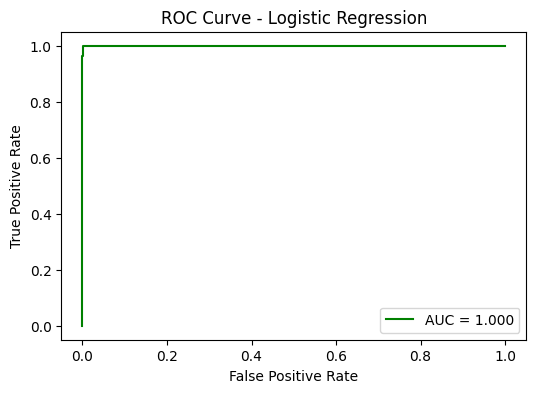

In [112]:
# Logistic Regression
# Ploting And Interpreting The AUC-ROC Curve For All The Models
y_prob_logistic = logistic_model_pipeline.predict_proba(x_test)[:,1]

# Predicting auc_roc_score to plot it in the graph
auc_roc_score_logistic = roc_auc_score(y_test,y_prob_logistic)

# Computing ROC Values
fpr,tpr,threshold = roc_curve(y_test,y_prob_logistic)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc_score_logistic:.3f}",color="green")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

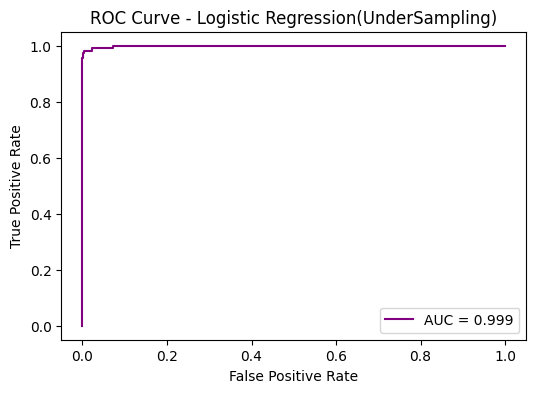

In [113]:
# Logistic Regression With UnderSampling Method
# Ploting And Interpreting The AUC-ROC Curve For All The Models
y_prob_logistic_undersample = lr_model[0].predict_proba(x_test2)[:,1]

# Predicting auc_roc_score to plot it in the graph
auc_roc_score_logistic_undersample = roc_auc_score(y_test2,y_prob_logistic_undersample)

# Computing ROC Values
fpr,tpr,threshold = roc_curve(y_test2,y_prob_logistic_undersample)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc_score_logistic_undersample:.3f}",color="purple")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression(UnderSampling)")
plt.legend()
plt.show()

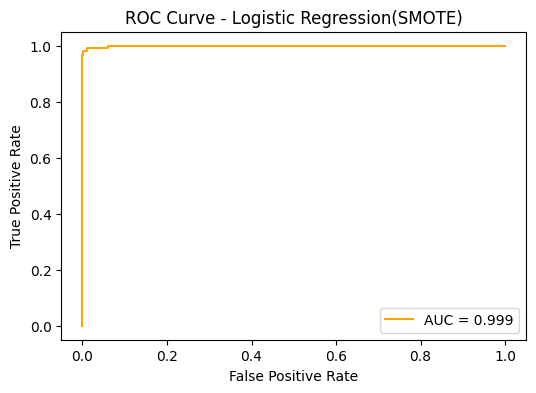

In [114]:
# Linear Regression With SMOTE Method
# Ploting And Interpreting The AUC-ROC Curve For All The Models
y_prob_logistic_undersample = lr_model[1].predict_proba(x_test2)[:,1]

# Predicting auc_roc_score to plot it in the graph
auc_roc_score_logistic_smote = roc_auc_score(y_test2,y_prob_logistic_undersample)

# Computing ROC Values
fpr,tpr,threshold = roc_curve(y_test2,y_prob_logistic_undersample)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc_score_logistic_smote:.3f}",color="orange")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression(SMOTE)")
plt.legend()
plt.show()

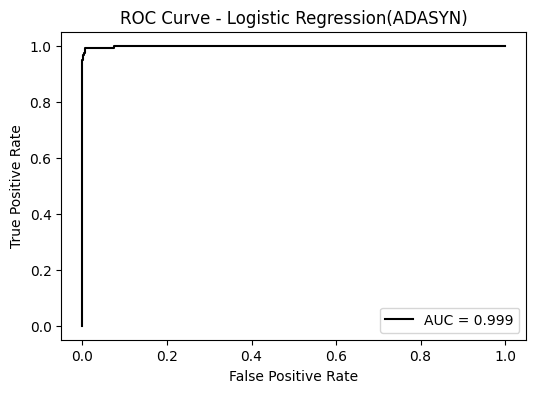

In [115]:
# Logistic Regression With ADASYN Method
# Ploting And Interpreting The AUC-ROC Curve For All The Models
y_prob_logistic_undersample = lr_model[2].predict_proba(x_test2)[:,1]

# Predicting auc_roc_score to plot it in the graph
auc_roc_score_logistic_adasyn = roc_auc_score(y_test2,y_prob_logistic_undersample)

# Computing ROC Values
fpr,tpr,threshold = roc_curve(y_test2,y_prob_logistic_undersample)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc_score_logistic_adasyn:.3f}",color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression(ADASYN)")
plt.legend()
plt.show()

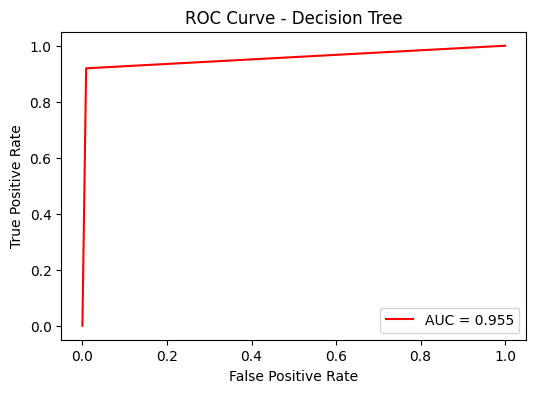

In [116]:
# Decision Tree Classifier
# Ploting And Interpreting The AUC-ROC Curve For All The Models
y_prob_decision = decisiontree_model_pipeline.predict_proba(x_test3)[:,1]

# Predicting auc_roc_score to plot it in the graph
auc_roc_score_decision = roc_auc_score(y_test3,y_prob_decision)

# Computing ROC Values
fpr,tpr,threshold = roc_curve(y_test3,y_prob_decision)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc_score_decision:.3f}",color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()

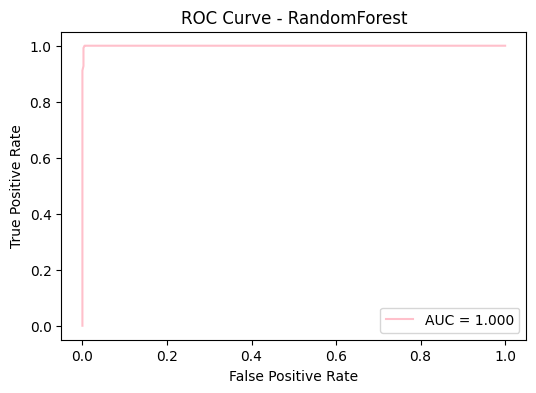

In [117]:
# Random Forest Classifier
# Ploting And Interpreting The AUC-ROC Curve For All The Models
y_prob_randomforest = randomforest_model_pipeline.predict_proba(x_test4)[:,1]

# Predicting auc_roc_score to plot it in the graph
auc_roc_score_randomforest = roc_auc_score(y_test4,y_prob_randomforest)

# Computing ROC Values
fpr,tpr,threshold = roc_curve(y_test4,y_prob_randomforest)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc_score_randomforest:.3f}",color="pink")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RandomForest")
plt.legend()
plt.show()

- From All The Above AUC-ROC Curves Of All Models It's Clearly Seen That All The Curve Are Closer To The Top-Left Corner And It Indicates That It's Excellent Model.

#### CLEAR Interpretation
- Higher TPR(True Positive Rate) At Lower FPR(False Positive Rate) Means The Models Catches Risky Customer Which Are Likely To Miss Payments And Also Without Wrongly Flagging Too Many Safe One.

In [118]:
# Finding The Best Model With Reference Of AUC-ROC Scores
auc_roc_final_dict = {
    "Logistic Regression" : auc_roc_score_logistic,
    "Logistic Regression_UnderSampling" : auc_roc_score_logistic_undersample,
    "Logistic Regression_SMOTE" : auc_roc_score_logistic_smote,
    "Logistic Regression_ADASYN" : auc_roc_score_logistic_adasyn,
    "DecisionTreeClassifier" : auc_roc_score_decision,
    "RandomForestClassifier" : auc_roc_score_randomforest
}

print(f"Among All The Evaluated Models {max(auc_roc_final_dict)} Has Deliverd And Performed Well By Achieving \nAUC-ROC Score Of {auc_roc_final_dict[max(auc_roc_final_dict)]}")

Among All The Evaluated Models RandomForestClassifier Has Deliverd And Performed Well By Achieving 
AUC-ROC Score Of 0.9997872426649376


### Part - H Is In Word File.